In [18]:
import argparse
import math
import time

import torch
import torch.nn as nn
import DCM_DeepCausal
import numpy as np;
#import importlib
from utils import *;

import Optim
import scipy

import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
from numpy import linalg as LA

In [19]:
#default setting
class args:
# data130allActivateNoise_nonlinear7 data40allActivateNoise
    data = 'data/Yao/Paper65/filter_norm_expression0.mat'
    graph_path = 'data/Yao/Paper65/groundtruth.mat'
    GTu_path = 'data/Yao/Paper65/groundtruth.mat'
    train = 0.95
    valid = 0.01
    model = 'DCM_DeepCausal'
    
    window = 10
    lowrank = 25
    y_dim = 39

    pre_win = 3
    p_list = [30]*5
    compress_p_list = [50]
    L1Loss = False#False
    clip = 1.
    epochs = 300
    batch_size = 50
    dropout = 0.05
    seed = 12345
    gpu = 0
    save = 'save/model.pt'
    cuda = False
    optim = 'adam'#'adam'
    lr = 0.01
    lr_decay = 1
    start_decay_at = 100
    weight_decay = 0
    horizon = 1
    normalize = 1



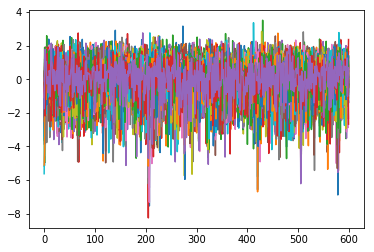

In [20]:
rawdat = loadmat(args.data)['expression']
plt.plot(rawdat)

In [21]:
rawdat.shape

(600, 65)

In [22]:
manualSeed = args.seed

np.random.seed(manualSeed)
#random.seed(manualSeed)
torch.manual_seed(manualSeed)
if args.cuda is True:
    torch.cuda.manual_seed(manualSeed)
    torch.cuda.manual_seed_all(manualSeed)
    torch.backends.cudnn.enabled = False 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [23]:
if args.cuda:
    print("a")
    torch.cuda.set_device(args.gpu)
# Set the random seed manually for reproducibility.
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    print("b")
    if not args.cuda:
        print("c")
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
    else:
        print("d")
        torch.cuda.manual_seed(args.seed)

b
c


In [24]:
Data = Data_utility(args)


data shape (600, 65)


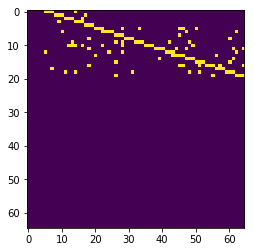

In [25]:
GroundTruth = loadmat(args.graph_path)['A']
GroundTruth_flat = GroundTruth.reshape(Data.m*Data.m)

#Recover = np.dot(np.dot(GTu, np.diag(GTs)), GTv)
#plt.imshow(Recover)
##Recover = Recover.reshape(Data.m*Data.m)
#fpr, tpr, thresholds = metrics.roc_curve(GroundTruth_flat, Recover)
#rocauc = (metrics.auc(fpr, tpr))
3#precision, recall, threshold = metrics.precision_recall_curve(GroundTruth_flat, Recover)
#aupr = metrics.auc(recall, precision)
#print('|ROC_AUC:{:5.4f}|PR_AUC:{:5.4f}'.format(rocauc, aupr))

#Change_GroundTruth = np.linalg.matrix_power(GroundTruth, 1)
#Change_GroundTruth = Change_GroundTruth.reshape(Data.m*Data.m)
#precision, recall, threshold = metrics.precision_recall_curve(GroundTruth_flat, Change_GroundTruth)
#aupr2 = metrics.auc(recall, precision)
#Change_GroundTruth = np.linalg.matrix_power(GroundTruth, 2)
#Change_GroundTruth = Change_GroundTruth.reshape(Data.m*Data.m)
##precision, recall, threshold = metrics.precision_recall_curve(GroundTruth_flat, Change_GroundTruth)
#upr3 = metrics.auc(recall, precision)
#hange_GroundTruth = np.linalg.matrix_power(GroundTruth, 3)
#hange_GroundTruth = Change_GroundTruth.reshape(Data.m*Data.m)
#recision, recall, threshold = metrics.precision_recall_curve(GroundTruth_flat, Change_GroundTruth)
#upr4 = metrics.auc(recall, precision)
#hange_GroundTruth = np.linalg.matrix_power(GroundTruth, 4)
#hange_GroundTruth = Change_GroundTruth.reshape(Data.m*Data.m)
#recision, recall, threshold = metrics.precision_recall_curve(GroundTruth_flat, Change_GroundTruth)
#pr5 = metrics.auc(recall, precision)
#rint('|PR_AUC2:{:5.4f}|PR_AUC3:{:5.4f}|PR_AUC4:{:5.4f}|PR_AUC5:{:5.4f}'.format(aupr2,aupr3,aupr4,aupr5))
plt.imshow(GroundTruth)

In [26]:
print('buliding model')
model = eval(args.model).Model(args, Data);


print(model.linears)

if args.cuda:
    model.cuda()

nParams = sum([p.nelement() for p in model.parameters()])
print('* number of parameters: %d' % nParams)

if args.L1Loss:
    criterion = nn.L1Loss(size_average=False);
else:
    criterion = nn.MSELoss(size_average=False);#,reduce=False);
evaluateL2 = nn.MSELoss(size_average=False);
evaluateL1 = nn.L1Loss(size_average=False)
if args.cuda:
    criterion = criterion.cuda()
    evaluateL1 = evaluateL1.cuda();
    evaluateL2 = evaluateL2.cuda();


best_val = 10000000;
optim = Optim.Optim(
    model.parameters(), args.optim, args.lr, args.clip, start_decay_at = args.start_decay_at, weight_decay = args.weight_decay)
test_acc, test_rae, test_corr = 0, 0, 0

buliding model
ModuleList(
  (0): Linear(in_features=10, out_features=30, bias=True)
  (1): Linear(in_features=30, out_features=30, bias=True)
  (2): Linear(in_features=30, out_features=30, bias=True)
  (3): Linear(in_features=30, out_features=30, bias=True)
  (4): Linear(in_features=30, out_features=30, bias=True)
  (5): BD_Model()
  (6): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): SV_Model()
  (9): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): BD_Model()
  (12): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): BD_Model()
  (15): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [27]:
def evaluate(loader, data, model, evaluateL2, evaluateL1, batch_size):
    model.eval()
    total_loss = 0
    total_loss_l1 = 0
    n_samples = 0

    alpha_loss = 0.
    beta_loss = 0.
    
    for inputs in loader.get_batches_bi(data, batch_size, False):
        X_fw, Y, X_bw = inputs[0], inputs[1], inputs[2]
        output = model(X_fw, X_bw)
        
        loss_org = criterion(output, Y)
        total_loss += loss_org.data.item()   
        n_samples += (output.size(0) * loader.m)
    
    return total_loss / n_samples

In [11]:
def train(loader, data, model, criterion, optim, batch_size, GroundTruth_flat):
    model.train();
    total_loss = 0
    mse = 0
    n_samples = 0
    
    
    total_time = 0
    
    for inputs in loader.get_batches_bi(data, batch_size, True):      
        X_fw, Y, X_bw = inputs[0], inputs[1], inputs[2]
        begin_time1 = time.time()

        model.zero_grad()
        output = model(X_fw, X_bw)
        loss_org = criterion(output, Y);
        
        end_time1 = time.time()
        dt1 = end_time1 - begin_time1
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
    
        
        l2_reg = None
        otg_reg = None
        eye_reg = None
        similar_U = []
        similar_V = []
        for layer_i in range(len(model.linears)):
            if not isinstance(model.linears[layer_i], nn.InstanceNorm1d) and not isinstance(model.linears[layer_i], nn.BatchNorm1d):
                W = model.linears[layer_i].weight.transpose(0,1).cpu().detach().numpy()
                ## sparsity
                if W.ndim >=2 and W.shape[0]*W.shape[1]>=100 and model.sparse_label[layer_i]>0: ## sparsity
                    if l2_reg is None:
                        l2_reg = LA.norm(W)
                    else:
                        l2_reg = l2_reg + LA.norm(W)
                ## orthgonality
                if W.ndim >=2 and model.orthgonal_label[layer_i]==1: 
                    if otg_reg is None:
                        otg_reg = LA.norm(np.abs(np.dot(W,np.transpose(W))-np.eye(W.shape[0])))
                    else:
                        otg_reg = otg_reg + LA.norm(np.abs(np.dot(W, np.transpose(W))-np.eye(W.shape[0])))
        
        batch_loss = loss_org + abs(l2_reg)*1.0+ abs(otg_reg)*0.1 
        begin_time2 = time.time()
        
        batch_loss.backward()
        total_loss += batch_loss.data.item();
        mse += loss_org.data.item()
        
        end_time2 = time.time()
        
        dt2 = end_time2 - begin_time2
        total_time = total_time + dt1 + dt2
        
                
        optim.step()
        n_samples += (output.size(0) * loader.m);
            
    return total_loss / n_samples, mse / n_samples, total_time

In [12]:
print("begin training")
train_loss_set = []
test_loss_set = []
mse_set = []
L1_W_loss_set = []
L1_L_loss_set = []
AUC_1 = []
AUC_2 = []
AUC_3 = []
AUC_4 = []

num_weight_plot = min([len(model.linears),50])
weight_norm = np.zeros((args.epochs, num_weight_plot))
auc1_best = 0.1
G_best = np.zeros((model.m, model.m))
#pdb.set_trace()
weight_matrix = []
for epoch in range(0, args.epochs):
    
    train_loss, mse, epoch_time = train(Data, Data.train_bi, model, criterion, optim, args.batch_size, GroundTruth_flat)
    val_loss = evaluate(Data, Data.valid_bi, model, evaluateL2, evaluateL1, args.batch_size)
    
    
    optim.updateLearningRate(val_loss, epoch)
    
    epoch_end_time = time.time()
    
    CGraph1, CGraph2, CGraph3, CGraph4 = model.predict_relationship()
    CGraph = CGraph1.reshape(model.m*model.m)
    #fpr, tpr, thresholds = metrics.roc_curve(GroundTruth_flat, CGraph)
    #auc1 = (metrics.auc(fpr, tpr))
    precision, recall, threshold = metrics.precision_recall_curve(GroundTruth_flat, CGraph)
    auc1 = metrics.auc(recall, precision)
    CGraph = CGraph2.reshape(model.m*model.m)
    #fpr, tpr, thresholds = metrics.roc_curve(GroundTruth_flat, CGraph)
    #auc2 = (metrics.auc(fpr, tpr))
    precision, recall, threshold = metrics.precision_recall_curve(GroundTruth_flat, CGraph)
    auc2 = metrics.auc(recall, precision)
    CGraph = CGraph1.reshape(model.m*model.m)
    fpr, tpr, thresholds = metrics.roc_curve(GroundTruth_flat, CGraph)
    auc3 = (metrics.auc(fpr, tpr))
    #precision, recall, threshold = metrics.precision_recall_curve(GroundTruth_flat, CGraph)
    #auc3 = metrics.auc(recall, precision)
    CGraph = CGraph2.reshape(model.m*model.m)
    fpr, tpr, thresholds = metrics.roc_curve(GroundTruth_flat, CGraph)
    auc4 = (metrics.auc(fpr, tpr))
    #precision, recall, threshold = metrics.precision_recall_curve(GroundTruth_flat, CGraph)
    #auc4 = metrics.auc(recall, precisi
        
    for layer_i in range(num_weight_plot):
        if not isinstance(model.linears[layer_i], nn.InstanceNorm1d):
            tmp = model.linears[layer_i].weight.cpu().detach().numpy()
            if tmp.ndim >2:
                tmp = tmp[:,:,0]
            weight_norm[epoch, layer_i] = LA.norm(tmp)
        
    
    train_loss_set.append(train_loss)
    test_loss_set.append(val_loss)
    mse_set.append(mse)
    AUC_1.append(auc1)
    AUC_2.append(auc2)
    AUC_3.append(auc3)
    AUC_4.append(auc4)
    print('|end_epoch{:3d}|time:{:5.2f}s|tn_ls {:5.8f}| mse {:5.8f} |vd_ls {:5.4f}|auc1 {:5.4f}|auc2 {:5.4f}|auc3 {:5.4f}|auc4 {:5.4f}'.format(epoch, epoch_time, train_loss, mse, val_loss, auc1, auc2, auc3, auc4))
    # Save the model if the validation loss is the best we've seen so far.
    
    if auc1>=auc1_best:
        G_best = CGraph1           
        
    if val_loss < best_val:
        best_val = val_loss
        test_loss  = evaluate(Data, Data.test_bi, model, evaluateL2, evaluateL1, args.batch_size);
        

begin training


/home/chenxiao/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


|end_epoch  0|time: 2.96s|tn_ls 2.87395948| mse 2.84683347 |vd_ls 2.8502|auc1 0.3591|auc2 0.3591|auc3 0.8412|auc4 0.8412
|end_epoch  1|time: 2.83s|tn_ls 2.04871585| mse 2.01801384 |vd_ls 1.8342|auc1 0.5316|auc2 0.5316|auc3 0.9399|auc4 0.9399
|end_epoch  2|time: 3.46s|tn_ls 1.75063396| mse 1.71722475 |vd_ls 1.5161|auc1 0.6121|auc2 0.6121|auc3 0.9542|auc4 0.9542
|end_epoch  3|time: 2.93s|tn_ls 1.63210833| mse 1.59646458 |vd_ls 1.4520|auc1 0.6517|auc2 0.6517|auc3 0.9587|auc4 0.9587
|end_epoch  4|time: 4.15s|tn_ls 1.55420277| mse 1.51644704 |vd_ls 1.3907|auc1 0.6816|auc2 0.6816|auc3 0.9610|auc4 0.9610
Decaying learning rate to 0.01
|end_epoch  5|time: 3.41s|tn_ls 1.50799697| mse 1.46814221 |vd_ls 1.4055|auc1 0.7016|auc2 0.7016|auc3 0.9630|auc4 0.9630
|end_epoch  6|time: 3.03s|tn_ls 1.45909738| mse 1.41722819 |vd_ls 1.3174|auc1 0.7029|auc2 0.7029|auc3 0.9615|auc4 0.9615
|end_epoch  7|time: 2.89s|tn_ls 1.42501848| mse 1.38111476 |vd_ls 1.2897|auc1 0.7064|auc2 0.7064|auc3 0.9612|auc4 0.9612
D

Decaying learning rate to 0.01
|end_epoch 62|time: 2.60s|tn_ls 1.19518121| mse 1.06558382 |vd_ls 1.1393|auc1 0.7907|auc2 0.7907|auc3 0.9723|auc4 0.9723
Decaying learning rate to 0.01
|end_epoch 63|time: 2.88s|tn_ls 1.19074217| mse 1.05975203 |vd_ls 1.1397|auc1 0.7976|auc2 0.7976|auc3 0.9731|auc4 0.9731
|end_epoch 64|time: 2.90s|tn_ls 1.19480460| mse 1.06244060 |vd_ls 1.1127|auc1 0.7961|auc2 0.7961|auc3 0.9734|auc4 0.9734
Decaying learning rate to 0.01
|end_epoch 65|time: 2.65s|tn_ls 1.18608360| mse 1.05246810 |vd_ls 1.1274|auc1 0.7942|auc2 0.7942|auc3 0.9725|auc4 0.9725
Decaying learning rate to 0.01
|end_epoch 66|time: 2.35s|tn_ls 1.18640051| mse 1.05145315 |vd_ls 1.1306|auc1 0.7969|auc2 0.7969|auc3 0.9736|auc4 0.9736
|end_epoch 67|time: 2.47s|tn_ls 1.19408117| mse 1.05773937 |vd_ls 1.1289|auc1 0.7982|auc2 0.7982|auc3 0.9746|auc4 0.9746
Decaying learning rate to 0.01
|end_epoch 68|time: 2.79s|tn_ls 1.19017008| mse 1.05252481 |vd_ls 1.1467|auc1 0.7942|auc2 0.7942|auc3 0.9744|auc4 0.974

Decaying learning rate to 0.01
|end_epoch120|time: 2.60s|tn_ls 1.21317267| mse 1.00901688 |vd_ls 1.1128|auc1 0.7896|auc2 0.7896|auc3 0.9732|auc4 0.9732
Decaying learning rate to 0.01
|end_epoch121|time: 2.56s|tn_ls 1.21451606| mse 1.00927528 |vd_ls 1.0927|auc1 0.7921|auc2 0.7921|auc3 0.9729|auc4 0.9729
Decaying learning rate to 0.01
|end_epoch122|time: 2.54s|tn_ls 1.21587671| mse 1.00943384 |vd_ls 1.1081|auc1 0.7945|auc2 0.7945|auc3 0.9740|auc4 0.9740
Decaying learning rate to 0.01
|end_epoch123|time: 2.53s|tn_ls 1.21137533| mse 1.00366165 |vd_ls 1.1202|auc1 0.7947|auc2 0.7947|auc3 0.9737|auc4 0.9737
Decaying learning rate to 0.01
|end_epoch124|time: 2.53s|tn_ls 1.21950414| mse 1.01055596 |vd_ls 1.1228|auc1 0.7942|auc2 0.7942|auc3 0.9737|auc4 0.9737
Decaying learning rate to 0.01
|end_epoch125|time: 2.56s|tn_ls 1.20985651| mse 0.99966358 |vd_ls 1.1259|auc1 0.7916|auc2 0.7916|auc3 0.9727|auc4 0.9727
Decaying learning rate to 0.01
|end_epoch126|time: 2.53s|tn_ls 1.21380275| mse 1.0025116

Decaying learning rate to 0.01
|end_epoch174|time: 2.91s|tn_ls 1.24856962| mse 0.98030316 |vd_ls 1.1482|auc1 0.7921|auc2 0.7921|auc3 0.9744|auc4 0.9744
Decaying learning rate to 0.01
|end_epoch175|time: 2.87s|tn_ls 1.25627115| mse 0.98681365 |vd_ls 1.1480|auc1 0.7918|auc2 0.7918|auc3 0.9741|auc4 0.9741
Decaying learning rate to 0.01
|end_epoch176|time: 2.79s|tn_ls 1.24752653| mse 0.97688052 |vd_ls 1.1437|auc1 0.7950|auc2 0.7950|auc3 0.9744|auc4 0.9744
Decaying learning rate to 0.01
|end_epoch177|time: 2.70s|tn_ls 1.24725603| mse 0.97545311 |vd_ls 1.1261|auc1 0.7942|auc2 0.7942|auc3 0.9746|auc4 0.9746
Decaying learning rate to 0.01
|end_epoch178|time: 2.54s|tn_ls 1.25005815| mse 0.97701489 |vd_ls 1.1257|auc1 0.7919|auc2 0.7919|auc3 0.9737|auc4 0.9737
Decaying learning rate to 0.01
|end_epoch179|time: 2.51s|tn_ls 1.25170395| mse 0.97747597 |vd_ls 1.1155|auc1 0.7950|auc2 0.7950|auc3 0.9738|auc4 0.9738
Decaying learning rate to 0.01
|end_epoch180|time: 2.56s|tn_ls 1.24876153| mse 0.9734349

Decaying learning rate to 0.01
|end_epoch228|time: 2.74s|tn_ls 1.30494934| mse 0.97442867 |vd_ls 1.1136|auc1 0.7876|auc2 0.7876|auc3 0.9733|auc4 0.9733
Decaying learning rate to 0.01
|end_epoch229|time: 2.66s|tn_ls 1.29361989| mse 0.96181294 |vd_ls 1.1380|auc1 0.7875|auc2 0.7875|auc3 0.9725|auc4 0.9725
Decaying learning rate to 0.01
|end_epoch230|time: 2.51s|tn_ls 1.29885621| mse 0.96587917 |vd_ls 1.1239|auc1 0.7870|auc2 0.7870|auc3 0.9727|auc4 0.9727
Decaying learning rate to 0.01
|end_epoch231|time: 2.53s|tn_ls 1.29600654| mse 0.96196229 |vd_ls 1.0910|auc1 0.7921|auc2 0.7921|auc3 0.9734|auc4 0.9734
Decaying learning rate to 0.01
|end_epoch232|time: 2.53s|tn_ls 1.29352940| mse 0.95859341 |vd_ls 1.0969|auc1 0.7900|auc2 0.7900|auc3 0.9721|auc4 0.9721
Decaying learning rate to 0.01
|end_epoch233|time: 2.54s|tn_ls 1.29715289| mse 0.96099135 |vd_ls 1.0936|auc1 0.7888|auc2 0.7888|auc3 0.9730|auc4 0.9730
Decaying learning rate to 0.01
|end_epoch234|time: 2.52s|tn_ls 1.30563501| mse 0.9682569

Decaying learning rate to 0.01
|end_epoch282|time: 2.52s|tn_ls 1.35573884| mse 0.96291058 |vd_ls 1.1255|auc1 0.7752|auc2 0.7752|auc3 0.9730|auc4 0.9730
Decaying learning rate to 0.01
|end_epoch283|time: 2.51s|tn_ls 1.35282232| mse 0.95874550 |vd_ls 1.1203|auc1 0.7772|auc2 0.7772|auc3 0.9729|auc4 0.9729
Decaying learning rate to 0.01
|end_epoch284|time: 2.50s|tn_ls 1.34906388| mse 0.95366372 |vd_ls 1.1129|auc1 0.7779|auc2 0.7779|auc3 0.9733|auc4 0.9733
Decaying learning rate to 0.01
|end_epoch285|time: 2.50s|tn_ls 1.35457700| mse 0.95785834 |vd_ls 1.1265|auc1 0.7775|auc2 0.7775|auc3 0.9732|auc4 0.9732
Decaying learning rate to 0.01
|end_epoch286|time: 2.50s|tn_ls 1.35524968| mse 0.95729903 |vd_ls 1.1097|auc1 0.7802|auc2 0.7802|auc3 0.9734|auc4 0.9734
Decaying learning rate to 0.01
|end_epoch287|time: 2.51s|tn_ls 1.34760413| mse 0.94860945 |vd_ls 1.1099|auc1 0.7812|auc2 0.7812|auc3 0.9737|auc4 0.9737
Decaying learning rate to 0.01
|end_epoch288|time: 2.50s|tn_ls 1.35423523| mse 0.9540776

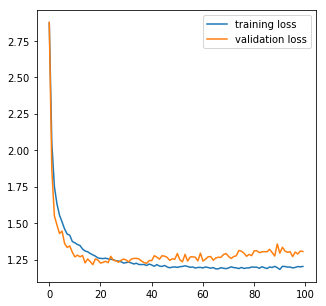

In [13]:
plt.figure(figsize=(5,5))


train_loss = np.array(train_loss_set[:100])
mse = np.array(mse_set[:100])
test_loss = np.array(test_loss_set[:100])
plt.plot(train_loss, label = 'training loss')
plt.plot(test_loss + train_loss - mse, label = 'validation loss')
plt.legend(loc = 'best')

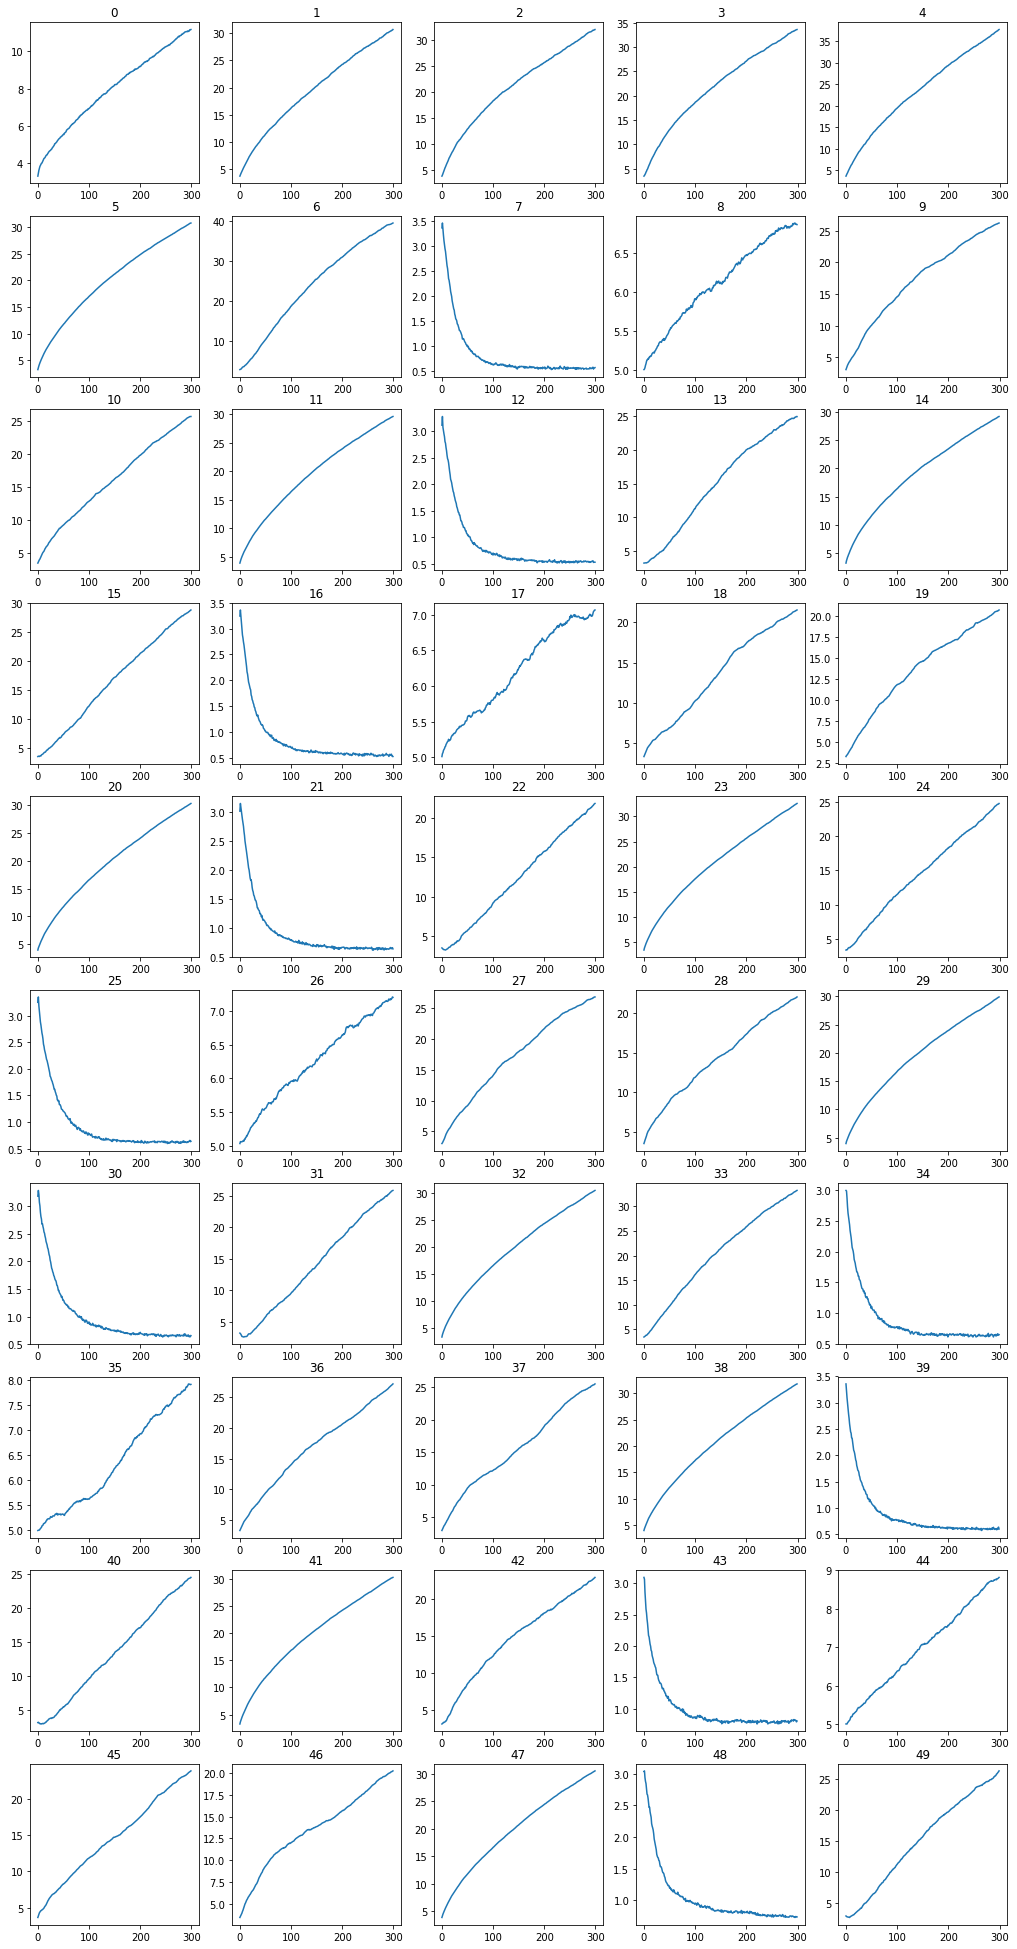

In [14]:
num_col = 5
num_rows = int(math.ceil( 1.0*num_weight_plot/num_col))
figure, axarr = plt.subplots(num_rows, num_col, sharex=True, figsize=(3.5*num_col,3.5*num_rows))   
for layer_i in range(num_weight_plot):
    ax_tmp = plt.subplot2grid((num_rows, num_col), (int(math.floor(1.0*layer_i/num_col)), layer_i%num_col), colspan=1, rowspan=1)
    ax_tmp.set_title(str(layer_i))
    ax_tmp.plot(weight_norm[:, layer_i])

best trn_loss 1.1821|best val_loss 1.0769|best auc1 0.7982|best auc2 0.7982|best auc3 0.9748|best auc4 0.9748


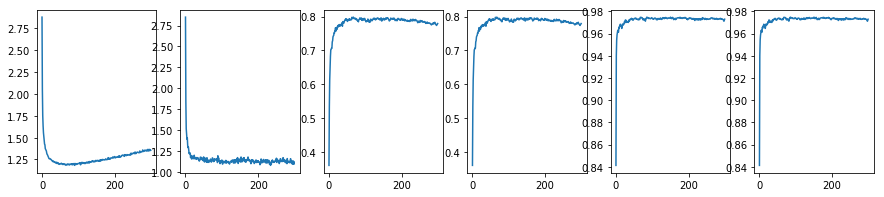

In [15]:
plt.figure(figsize=(15,3))
plt.subplot(161)
plt.plot(train_loss_set)
plt.subplot(162)
plt.plot(test_loss_set)
plt.subplot(163)
plt.plot(AUC_1)
plt.subplot(164)
plt.plot(AUC_2)
plt.subplot(165)
plt.plot(AUC_3)
plt.subplot(166)
plt.plot(AUC_4)
print ("best trn_loss {:5.4f}|best val_loss {:5.4f}|best auc1 {:5.4f}|best auc2 {:5.4f}|best auc3 {:5.4f}|best auc4 {:5.4f}".format(np.min(train_loss_set), np.min(test_loss_set), np.max(AUC_1), np.max(AUC_2), np.max(AUC_3),np.max(AUC_4)))

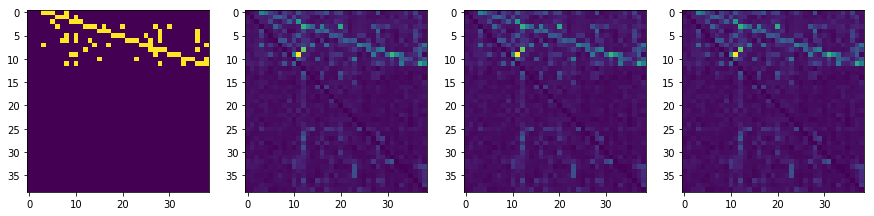

In [16]:
#pdb.set_trace() 
plt.figure(figsize=(15,3.5))
plt.subplot(141)
plt.imshow(GroundTruth)
plt.subplot(142)
plt.imshow(G_best)
plt.subplot(143)
plt.imshow(CGraph1)
plt.subplot(144)
plt.imshow(CGraph2)

Text(0.5, -0.15, 'estimated causal graph')

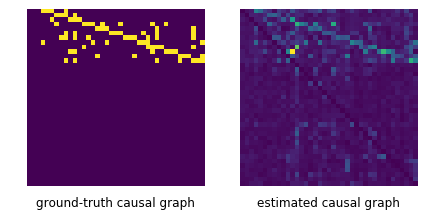

In [17]:
plt.figure(figsize=(7,3.5))
plt.subplot(121)
plt.imshow(GroundTruth)
plt.axis("off")
plt.title("ground-truth causal graph", y = -0.15)
plt.subplot(122)
plt.imshow(G_best)
plt.axis("off")
plt.title("estimated causal graph", y = -0.15)

In [ ]:
NofGenes = model.m
GroundTruth = GroundTruth.reshape(NofGenes*NofGenes)
G_best = G_best.reshape(NofGenes*NofGenes)
precision, recall, thresholds1 = metrics.precision_recall_curve(GroundTruth, G_best)
fpr, tpr, thresholds2 = metrics.roc_curve(GroundTruth, G_best)

plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.subplot(122)
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

print(metrics.auc(recall, precision)) 
print(metrics.auc(fpr, tpr))
print(NofGenes)

In [ ]:
P_weight=np.zeros(len(args.p_list))
for j in range(len(args.p_list)):
    P_weight[j] = model.P[j].weight

plt.plot(P_weight)

In [ ]:
from matplotlib import figure
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (19, 30)
plt.imshow(np.transpose(weight_matrix))
plt.ylabel('layers')
plt.xlabel('epoches')

In [ ]:
train_loss_39 = train_loss_set
mse_loss_39 = mse_set
test_loss_39 = test_loss_set



In [ ]:
plt.figure(figsize=(14,7))

train_loss_130 = train_loss_set
mse_loss_130 = mse_set
test_loss_130 = test_loss_set
AUC_130 = AUC_1
plt.subplot(1,2,1)

plt.plot(train_loss_130, label = 'training_loss')
plt.plot(mse_loss_130, label = 'mean square error')
plt.plot(test_loss_130, label = 'validation loss')

plt.legend(loc = "best")

plt.subplot(1,2,2)
plt.plot(AUC_130, label = 'AUPR')
plt.legend(loc = "best")



In [ ]:
plt.figure(figsize=(14,14))
AUC_39 = AUC_1
plt.subplot(2,2,1)
plt.title("Gene 39")

plt.plot(train_loss_39, label = 'training_loss')
plt.plot(mse_loss_39, label = 'mean square error')
plt.plot(test_loss_39, label = 'validation loss')

plt.legend(loc = "best")

plt.subplot(2,2,3)
plt.plot(AUC_39, label = 'AUPR')

plt.legend(loc = "best")

plt.xlabel("epochs")




AUC_130 = AUC_1
plt.subplot(2,2,2)
plt.title("Gene 130")

plt.plot(train_loss_130, label = 'training_loss')
plt.plot(mse_loss_130, label = 'mean square error')
plt.plot(test_loss_130, label = 'validation loss')

plt.legend(loc = "best")

plt.subplot(2,2,4)
plt.plot(AUC_130, label = 'AUPR')

plt.legend(loc = "best")


plt.xlabel("epochs")

In [ ]:
train_loss_array = np.array(train_loss_set)
mse_array = np.array(mse_set)
val_loss_array = np.array(test_loss_set)

import pandas as pd
Aggre_Result = pd.DataFrame()
Aggre_Result['training_loss'] = train_loss_array
Aggre_Result['mse'] = mse_array
Aggre_Result['val_loss'] = val_loss_array
Aggre_Result['AUPR'] = AUC_1
Aggre_Result.to_csv('loss_dataSet_B.csv', index = False)

Causal_Matrix = pd.DataFrame()
Causal_Matrix['groundtruth'] = GroundTruth
Causal_Matrix['estimate'] = G_best
Causal_Matrix.to_csv('Causal_Matrix_B_SCGL.csv', index = False)

In [ ]:
train_loss_array

In [ ]:
plt.plot(train_loss_array)